In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from IPython.display import display
plt.rcParams['figure.figsize'] = (16.0, 12.0)
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

In [3]:
from vidsummarai.models import video
from vidsummarai.helpers.load_data import get_video_objects

In [4]:
video_info_path = "../data/data/ydata-tvsum50-info.tsv"
anno_path = "../data/data/ydata-tvsum50-anno.tsv"

In [5]:
videos = get_video_objects(video_info_path, anno_path)

In [6]:
video_number = 20

In [7]:
print videos[video_number]


        Video Title: Poor Man's Meals: Spicy Sausage Sandwich
        Video Id: Yi4Ij2NM7U4
        Video Url: https://www.youtube.com/watch?v=Yi4Ij2NM7U4
        Video Duration: 405
        Video Genre: MS
        


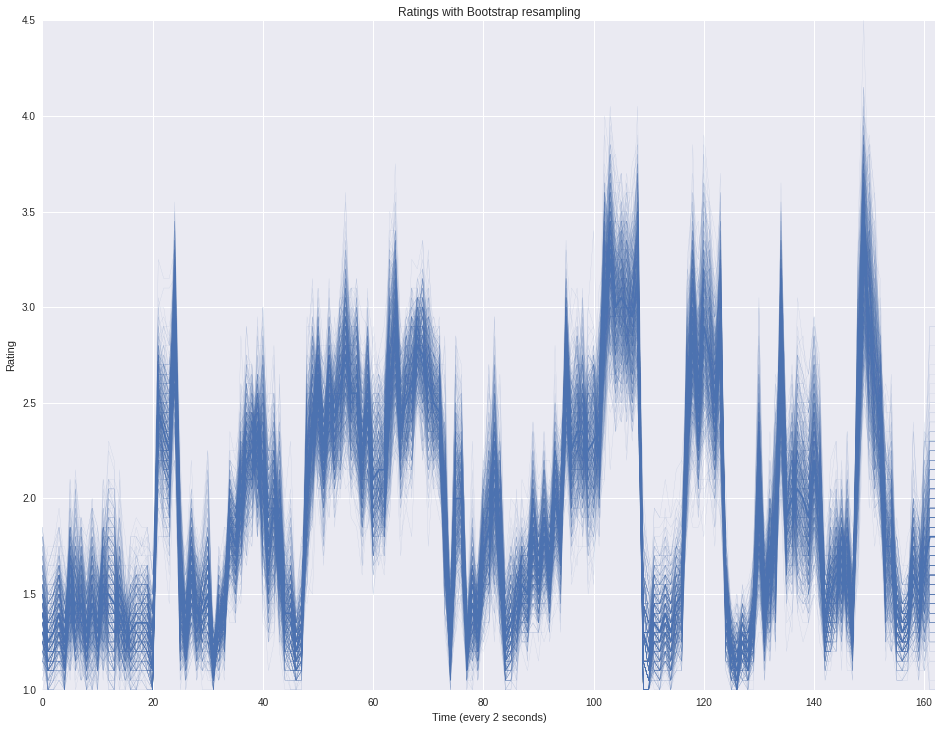

In [8]:
videos[video_number].plot_samples()

### Gaussian Process Regression

__RBF Kernel__

Here we attempt to use an RBF Kernel in our GP model.

lengthscale controls how many data points (on the x axis) we want our RBF to encorporate. Users annotate every 2 seconds, so 60 would represent 60 frames or 2 seconds. Increasing the lengthscale smooths out the Gaussian Process.

In [9]:
videos[video_number].fit_gaussian_process()


Name                              : GP regression
Log-likelihood                    : -4818.55240557
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance             |   2.29  |     +ve      |         |         
  rbf.lengthscale          |   60.0  |     +ve      |         |         
  Gaussian_noise.variance  |    1.0  |     +ve      |         |         


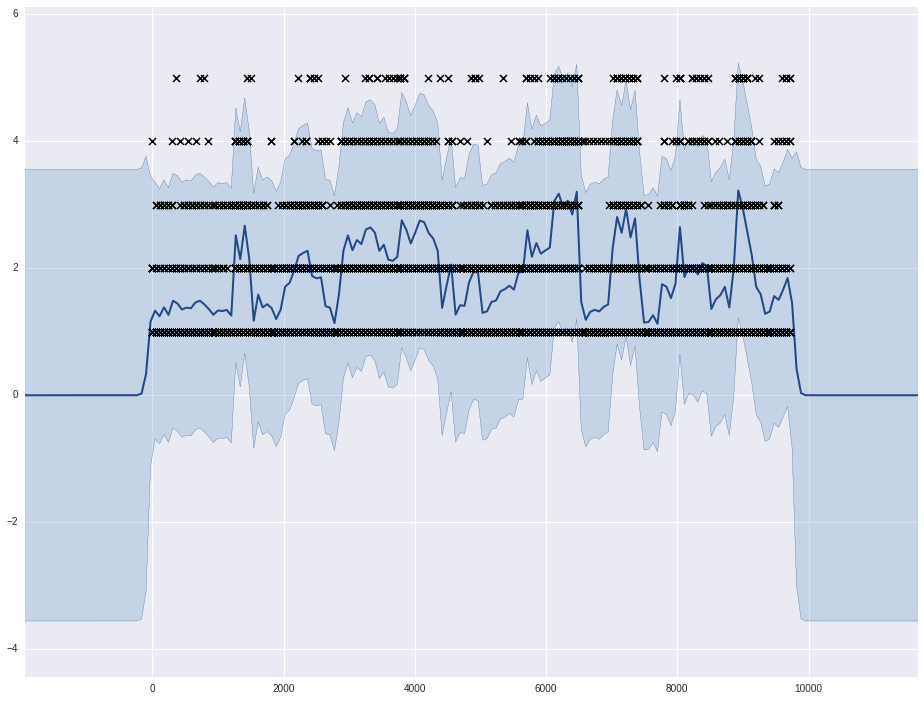

In [10]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
videos[video_number].plot_gaussian_process()
print videos[video_number].gp

__Optimize Params of GP__

We can use the built in functions of the GPy library to find the optimal value of variance and lengthscale for our GP.

In [11]:
videos[video_number].gp.optimize(messages=True)

 /home/ben/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



Name                              : GP regression
Log-likelihood                    : -4686.42857308
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance             |   2.50252336693  |     +ve      |         |         
  rbf.lengthscale          |   307.974644681  |     +ve      |         |         
  Gaussian_noise.variance  |  0.986422736069  |     +ve      |         |         


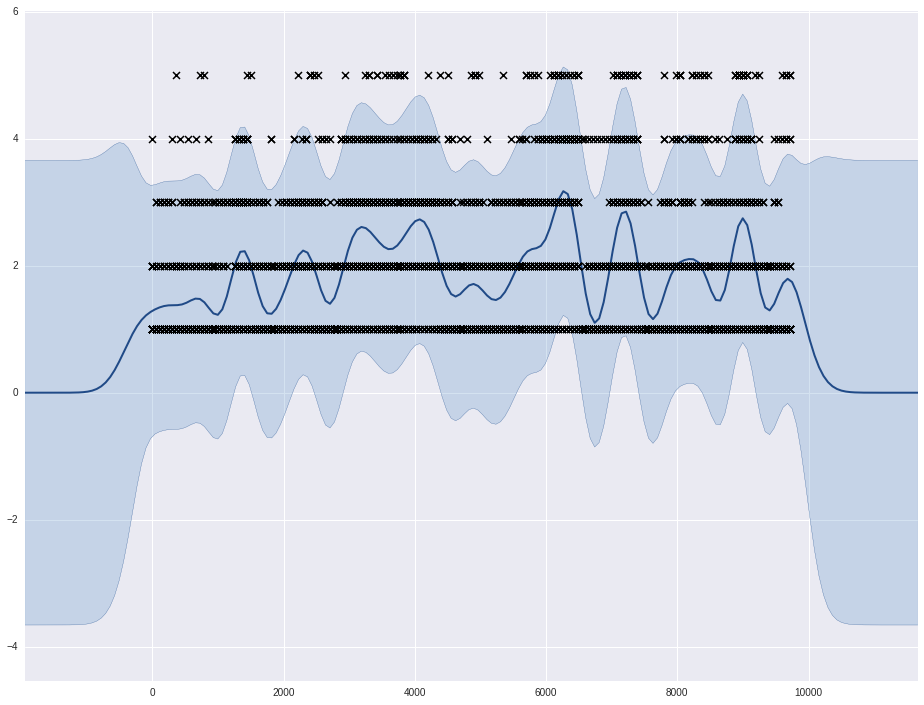

In [12]:
videos[video_number].plot_gaussian_process()
print videos[video_number].gp

 /home/ben/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


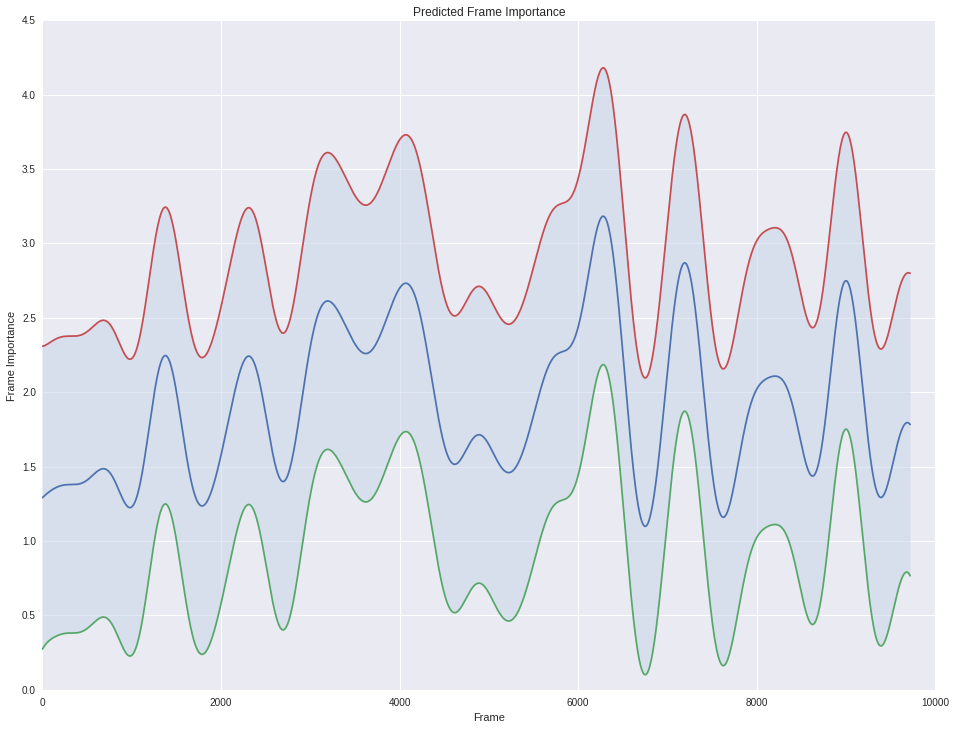

In [15]:
videos[video_number].plot_predictions()